Updated October 26. Designs probes against intergenic regions of entire tandem arrays. Uses the sequence with UTRs but without introns. Blasts against transcriptome with introns, transcriptome without introns, and intergenic databases to verify specificity. 
Author: Giacomo Glotzer. 

In [65]:
from pygenomeviz import GenomeViz
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import subprocess
import sys
sys.path.append('/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/analysis')
from transcriptomics import * 
from hcr import *
from plotting import * 

# Specify blast databases
new_transcriptome_db_no_introns = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/transcriptome/mRNA_no_introns/mRNA_no_introns"
new_transcriptome_db_yes_introns = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/transcriptome/mRNA_yes_introns/mRNA_yes_introns"
all_intergenic_regions_db = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/transcriptome/intergenics/all_intergenic_regions"

# Load genome
genome_fasta_path = '/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/genome/Obir.assembly.v5.4.fasta'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

# Load transcriptome
tr = load_transcriptome_object("/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/biroi_transcriptome.pkl")

# Load or_db
or_db = pd.read_excel('/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/OR List.xlsx') 

In [66]:
# set main directory for writing files 
main_directory = '/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/hcr-probe-design/intergenic_tandem_array_probe_design/'

In [67]:
# Specify TA 
TA = 79

In [68]:
# Get genes 
genes = or_db[or_db['tandem_array'] == TA]['gene_name'].values

# Get gene objects from tr 
gene_objects = [tr.get_gene(gene) for gene in genes]

# Print the number of genes 
print("Number of genes: ", len(gene_objects))

Number of genes:  12


In [69]:
# Get chromosome 
chromosome = gene_objects[0].chromosome
chromosome

'Chr1'

In [70]:
# Get bounds of each gene 
bounds = [gene.get_transcript_longest_bounds().get_bounds() for gene in gene_objects]
bounds

[[17883604, 17887432],
 [17889077, 17892268],
 [17894999, 17896696],
 [17897629, 17901737],
 [17903405, 17907766],
 [17909021, 17913704],
 [17913799, 17917697],
 [17918402, 17921931],
 [17923627, 17928349],
 [17930212, 17934286],
 [17935359, 17939546],
 [17940593, 17944491]]

In [71]:
# define a object called intergenic 
class Intergenic: 
    def __init__(self, count, gene_1, gene_2, chromosome, start, end, strand, sequence): 
        self.count = count 
        self.gene_1 = gene_1
        self.gene_2 = gene_2
        self.chromosome = chromosome
        self.start = start
        self.end = end
        self.strand = strand
        self.sequence = sequence
        self.length = len(sequence)
        self.name = f"{count}:{gene_1}-{gene_2}-{chromosome}:{start}-{end}-{strand}"

In [72]:
# Export gene sequence for each intergenic region for blasting against transcriptome 
output_dir = os.path.join(main_directory, 'intergenic_sequence_blast_input')

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# Make a list of intergenic regions and sequences, saving them to files for blasting 
intergenics = []
for i in range(len(bounds)-1): 
    # Verify the bounds contain at least 54 bp 
    if bounds[i+1][0] - bounds[i][1] > 54: 
        strand = gene_objects[i].strand # get strand 
        gene_1 = gene_objects[i].name 
        gene_2 = gene_objects[i+1].name
        intergenic_sequence = get_sequence(genome_seq, chromosome, bounds[i][1], bounds[i+1][0], strand)
        intergenic = Intergenic(i+1, gene_1, gene_2, chromosome, bounds[i][1], bounds[i+1][0], strand, intergenic_sequence)
        intergenics.append(intergenic)
        
        # Write to file 
        with open(f"{output_dir}/T{TA}_intergenic_{i+1}.fasta", 'w') as f:
            f.write(f">{intergenic.name}\n{intergenic_sequence}\n")

        print(f"Intergenic {i+1}: {chromosome}:{bounds[i][1]}-{bounds[i+1][0]} contains {len(intergenic_sequence)} bp")

Intergenic 1: Chr1:17887432-17889077 contains 1645 bp
Intergenic 2: Chr1:17892268-17894999 contains 2731 bp
Intergenic 3: Chr1:17896696-17897629 contains 933 bp
Intergenic 4: Chr1:17901737-17903405 contains 1668 bp
Intergenic 5: Chr1:17907766-17909021 contains 1255 bp
Intergenic 6: Chr1:17913704-17913799 contains 95 bp
Intergenic 7: Chr1:17917697-17918402 contains 705 bp
Intergenic 8: Chr1:17921931-17923627 contains 1696 bp
Intergenic 9: Chr1:17928349-17930212 contains 1863 bp
Intergenic 10: Chr1:17934286-17935359 contains 1073 bp
Intergenic 11: Chr1:17939546-17940593 contains 1047 bp


In [73]:
## Blast genes against the transcriptome without introns (mature mRNA), transcriptome with introns (pre-mRNA), and intergenic regions 
input_dir = os.path.join(main_directory, 'intergenic_sequence_blast_input')
output_dir = os.path.join(main_directory, 'intergenic_sequence_blast_output')

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")
    
for i, intergenic in enumerate(intergenics):
    input_path = f"{input_dir}/T{TA}_intergenic_{intergenic.count}.fasta"
    # no introns 
    output_path = f"{output_dir}/T{TA}_intergenic_{intergenic.count}_blasted_no_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_no_introns} -ungapped -word_size 15 -reward 1 -penalty -5 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)
    # yes introns
    output_path = f"{output_dir}/T{TA}_intergenic_{intergenic.count}_blasted_yes_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_yes_introns} -ungapped -word_size 15 -reward 1 -penalty -5 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)
    # intergenic 
    output_path = f"{output_dir}/T{TA}_intergenic_{intergenic.count}_blasted_intergenics.csv"
    command = f"blastn -task blastn -query {input_path} -db {all_intergenic_regions_db} -ungapped -word_size 15 -reward 1 -penalty -5 -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

In [74]:
length_thresh=50

## Iterate through blast results and annotate non-unique regions 
input_dir = os.path.join(main_directory, 'intergenic_sequence_blast_output')
output_dir = os.path.join(main_directory, 'intergenic_sequence_unique_regions') 

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")


for i, intergenic in enumerate(intergenics):
    
    # No introns
    input_path = f"{input_dir}/T{TA}_intergenic_{intergenic.count}_blasted_no_introns.csv"
    blast_results_no_introns = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results_no_introns['source'] = 'no_introns'

    # Yes introns
    input_path = f"{input_dir}/T{TA}_intergenic_{intergenic.count}_blasted_yes_introns.csv"
    blast_results_yes_introns = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results_yes_introns['source'] = 'yes_introns'

    # Yes introns
    input_path = f"{input_dir}/T{TA}_intergenic_{intergenic.count}_blasted_intergenics.csv"
    blast_results_intergenics = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results_intergenics['source'] = 'intergenics'

    # Concatenate 
    blast_results = pd.concat([blast_results_no_introns, blast_results_yes_introns, blast_results_intergenics], axis=0)

    # Remove blast_results < length_thresh
    blast_results = blast_results[blast_results['length'] >= length_thresh]

    # Label hits to intergenic regions by extracting the tandem array number 
    blast_results['intergenic_tandem_array'] = blast_results['subject_id'].apply(
        lambda x: int(x.split('-Or5')[0].split('T')[1]) # for intergenic regions
        if 'Chr' in x
        else ""
    )

    # Get off-targets: hits to anything other than the intergenic regions of interest
    off_targets = blast_results.loc[(blast_results['length'].values >= length_thresh) & # length threshold, no need for mismatch threshold here 
                                        (blast_results['intergenic_tandem_array'] != TA), :] # off-targets only 

    # Iterate through each row 
    sequence = intergenic.sequence

    # Annotate off-targets 
    for j, row in off_targets.iterrows():
        sequence = sequence[:row['q_start']] + '-'*(row['q_end'] - row['q_start']) + sequence[row['q_end']:]

    # Save the annotated sequence 
    intergenic.unique_sequence = sequence 

    # Save the blast results 
    intergenic.blast_results = blast_results

    # Save the sequence to new file 
    with open(f"{output_dir}/T{TA}_intergenic_{intergenic.count}_unique.fasta", 'w') as f:
        f.write(f">{intergenic.gene_1} - {intergenic.gene_2} {intergenic.chromosome}:{intergenic.start}-{intergenic.end} ({intergenic.strand})\n{sequence}\n")

print(f"Unique regions have been annotated and exported to {output_dir}")

Unique regions have been annotated and exported to /Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/hcr-probe-design/intergenic_tandem_array_probe_design/intergenic_sequence_unique_regions


In [75]:
intergenics[0].blast_results

,query_id,subject_id,subject_acc,percent_identity,length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,source,intergenic_tandem_array
0,1:Or5-9E4-Or5-9E5-Chr1:17887432-17889077--,gnl|WGS:QOIP|geneOr5-9E6-RA,WGS:QOIP:geneOr5-9E6-RA,99.448,362,2,0,1,362,1815,2176,0.000000e+00,700.0,no_introns,
1,1:Or5-9E4-Or5-9E5-Chr1:17887432-17889077--,gnl|WGS:QOIP|geneOr5-9E6-RA,WGS:QOIP:geneOr5-9E6-RA,100.000,90,0,0,1505,1594,111,200,8.300000e-44,180.0,no_introns,
2,1:Or5-9E4-Or5-9E5-Chr1:17887432-17889077--,gnl|WGS:QOIP|geneOr5-9E6-RA,WGS:QOIP:geneOr5-9E6-RA,93.671,79,5,0,1403,1481,7,85,3.890000e-19,98.4,no_introns,
5,1:Or5-9E4-Or5-9E5-Chr1:17887432-17889077--,gnl|WGS:QOIP|geneOr5-9E7-RA,WGS:QOIP:geneOr5-9E7-RA,97.484,159,4,0,1485,1643,278,436,6.930000e-71,270.0,no_introns,
6,1:Or5-9E4-Or5-9E5-Chr1:17887432-17889077--,gnl|WGS:QOIP|geneOr5-9E7-RA,WGS:QOIP:geneOr5-9E7-RA,94.488,127,7,0,1283,1409,77,203,8.460000e-41,170.0,no_introns,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,1:Or5-9E4-Or5-9E5-Chr1:17887432-17889077--,T79-Or5-9E10-Or5-9E11-Chr1:17921932-17923626,T79-Or5-9E10-Or5-9E11-Chr1:17921932-17923626,92.857,84,6,0,826,909,1211,1294,1.200000e-20,96.4,intergenics,79
32,1:Or5-9E4-Or5-9E5-Chr1:17887432-17889077--,T79-Or5-9E9-Or5-9E10-Chr1:17917698-17918401,T79-Or5-9E9-Or5-9E10-Chr1:17917698-17918401,90.625,96,9,0,785,880,252,347,4.910000e-17,84.4,intergenics,79
35,1:Or5-9E4-Or5-9E5-Chr1:17887432-17889077--,T82-Or5-9E17-Or5-9E18-Chr1:18741016-18743558,T82-Or5-9E17-Or5-9E18-Chr1:18741016-18743558,94.915,59,3,0,1351,1409,2301,2359,1.960000e-16,82.4,intergenics,82
36,1:Or5-9E4-Or5-9E5-Chr1:17887432-17889077--,T82-Or5-9E17-Or5-9E18-Chr1:18741016-18743558,T82-Or5-9E17-Or5-9E18-Chr1:18741016-18743558,92.593,54,4,0,1042,1095,570,623,8.160000e-10,60.4,intergenics,82


In [76]:
# Determine how many probes fit on each gene 
for i, intergenic in enumerate(intergenics):
    sequence = intergenic.unique_sequence 
    probes, regions, positions = design_hcr_probes(sequence, "B1")
    intergenic.num_available_probes = len(probes)


pd.set_option('display.max_colwidth', None)
num_probes = pd.DataFrame({'name': [intergenic.name for intergenic in intergenics], 'num_available_probes': [intergenic.num_available_probes for intergenic in intergenics]})
num_probes

,name,num_available_probes
0,1:Or5-9E4-Or5-9E5-Chr1:17887432-17889077--,9
1,2:Or5-9E5-Or5-9Efrag1-Chr1:17892268-17894999--,21
2,3:Or5-9Efrag1-Or5-9E6-Chr1:17896696-17897629--,4
3,4:Or5-9E6-Or5-9E7-Chr1:17901737-17903405--,21
4,5:Or5-9E7-Or5-9E8-Chr1:17907766-17909021--,9
5,6:Or5-9E8-Or5-9E9-Chr1:17913704-17913799--,0
6,7:Or5-9E9-Or5-9E10-Chr1:17917697-17918402--,5
7,8:Or5-9E10-Or5-9E11-Chr1:17921931-17923627--,14
8,9:Or5-9E11-Or5-9E12-Chr1:17928349-17930212--,11
9,10:Or5-9E12-Or5-9E13-Chr1:17934286-17935359--,12


In [77]:
# Specify amplifier 
amplifier = "B2"

In [78]:
# Specify how many probes per intergenic  
n_probes_per_intergenic = 7

In [79]:
# Export excel sheet with probes and excel sheet with probe binding regions 
all_probes = []
all_regions = []
for intergenic in intergenics: 
     
    # Design probes
    sequence = intergenic.unique_sequence
    probes, regions, positions = design_hcr_probes(sequence, amplifier)

    # Randomly select n_probes_per_gene probes 
    np.random.seed(0)
    if len(probes) < n_probes_per_intergenic:
        indices = range(len(probes))
    else: 
        indices = np.random.choice(range(len(probes)), n_probes_per_intergenic, replace=False)
    probes = [probes[i] for i in indices]
    regions = [regions[i] for i in indices]
    
    # Save probes and regions to gene object
    intergenic.probes = probes
    intergenic.regions = regions
    
    # Append to all_probes and all_regions
    all_probes.extend([probe for sublist in probes for probe in sublist])
    all_regions.extend(regions)

# Get date 
today = pd.Timestamp.now().strftime('%Y-%m-%d')

# Export probes 
output_dir = os.path.join(main_directory, 'IDT_sheets')

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create output path
output_path = f"{output_dir}/T{TA}-intergenic-{amplifier}-{today}.xlsx"
df = pd.DataFrame({'Sequence': all_probes})
df['Pool name'] = f'T{TA}-{amplifier}-intergenic'
df = df[['Pool name', 'Sequence']]
df.to_excel(output_path, index=False)
print(f"{len(all_probes)} probes have been exported to {output_path}")

# Export probe binding regions
output_dir = os.path.join(main_directory, 'probe_binding_regions_sheets') 

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create output path
output_path = f"{output_dir}/T{TA}-{amplifier}-intergenics-regions-{today}.xlsx"

# Make a vector of the gene names for each probe 
targets = [intergenic.name for intergenic in intergenics for _ in range(len(intergenic.probes))]
df = pd.DataFrame({'Target': [intergenic.name for intergenic in intergenics for _ in range(len(intergenic.regions))], 
                   'Region': all_regions, 
                   'Probe 1': [probe[0] for intergenic in intergenics for probe in intergenic.probes], 
                   'Probe 2': [probe[1] for intergenic in intergenics for probe in intergenic.probes]})
df.to_excel(output_path, index=False)


130 probes have been exported to /Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/hcr-probe-design/intergenic_tandem_array_probe_design/IDT_sheets/T79-intergenic-B2-2024-11-09.xlsx


In [80]:
# Export all_regions to individual fasta files 

output_dir = os.path.join(main_directory, 'probe_region_blast_input')
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# Export all_regions to individual fasta files in output_dir 
for i, region in enumerate(all_regions): 
    with open(f"{output_dir}/region-{i}.fasta", 'w') as f: 
        f.write(f">region-{i}\n{region}")

In [81]:
# Blast all regions against the transcriptome

input_dir = os.path.join(main_directory, 'probe_region_blast_input')
output_dir = os.path.join(main_directory, 'probe_region_blast_output') 

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# Blast each region against the transcriptome
for i, region in enumerate(all_regions): 
    input_path = f"{input_dir}/region-{i}.fasta"

    # Blast against transcriptome without introns
    output_path = f"{output_dir}/region-{i}-blasted_no_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_no_introns} -ungapped -word_size 15 -reward 1 -penalty -1 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

    # Blast against transcriptome with introns
    output_path = f"{output_dir}/region-{i}-blasted_yes_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_yes_introns} -ungapped -word_size 15 -reward 1 -penalty -1 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

    # Blast against intergenics 
    output_path = f"{output_dir}/region-{i}-blasted_intergenics.csv"
    command = f"blastn -task blastn -query {input_path} -db {all_intergenic_regions_db} -ungapped -word_size 15 -reward 1 -penalty -1 -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

print("All regions have been blasted")

All regions have been blasted


In [82]:
# Load in blast results
output_dir = os.path.join(main_directory, 'probe_region_blast_output') 
all_blast_results = []
for i, region in enumerate(regions):
    output_path = f"{output_dir}/region-{i}-blasted_no_introns.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'no_introns'
    all_blast_results.append(blast_results)
    output_path = f"{output_dir}/region-{i}-blasted_yes_introns.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'yes_introns'
    all_blast_results.append(blast_results)
    output_path = f"{output_dir}/region-{i}-blasted_intergenics.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'intergenics'
    all_blast_results.append(blast_results)

In [83]:
# Check for non-unique regions

num_hits_over_thresh = 0
length_thresh = 50
mismatch_thresh = 5 
all_off_targets = pd.DataFrame()

# Iterate through blast results 
for i, blast_results in enumerate(all_blast_results):
    if len(blast_results) == 0: 
        continue

    # Label hits to intergenic regions by extracting the tandem array number 
    blast_results['intergenic_tandem_array'] = blast_results['subject_id'].apply(
        lambda x: int(x.split('-Or5')[0].split('T')[1]) # for intergenic regions
        if 'Chr' in x
        else ""
    )

    # Get off-targets: hits to anything other than the intergenic regions of interest
    off_targets = blast_results.loc[(blast_results['length'].values >= length_thresh) & # length threshold, no need for mismatch threshold here 
                                        (blast_results['mismatches'].values <= mismatch_thresh) & # mismatch threshold
                                        (blast_results['intergenic_tandem_array'] != TA), :] # off-targets only 

    # Add to the all_off_targets dataframe
    all_off_targets = pd.concat([all_off_targets, off_targets])

    # Update num_hits_over_thresh   
    num_hits_over_thresh += len(off_targets)

print(f"Found {num_hits_over_thresh} off-target hits with length >= {length_thresh}bp, mismatches <= {mismatch_thresh}")

Found 0 off-target hits with length >= 50bp, mismatches <= 5


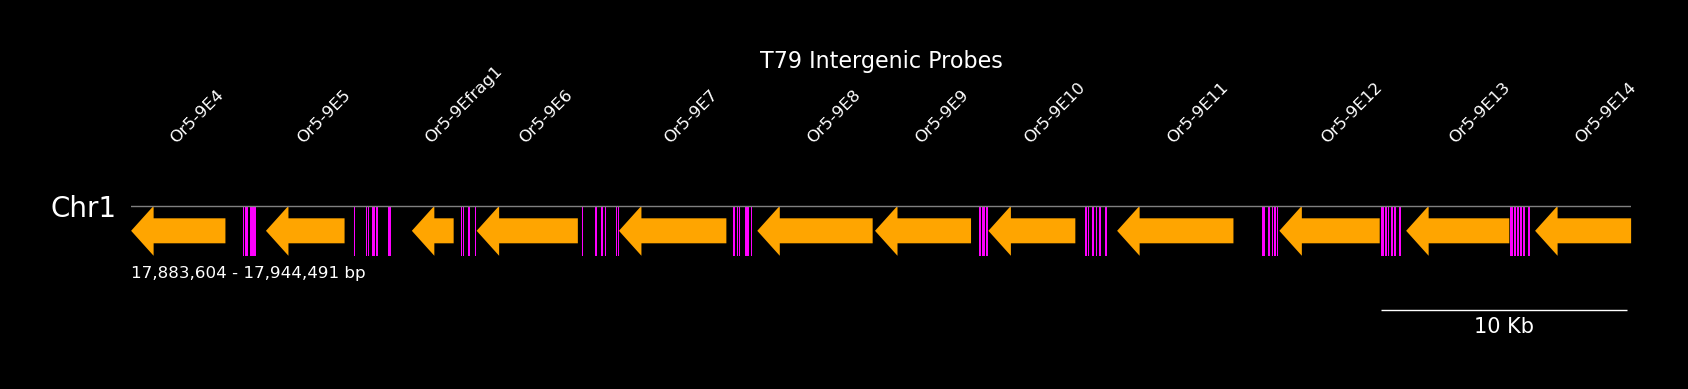

In [84]:
# Create a new GenomeViz object
black_plotting()
gv = GenomeViz(track_align_type="center", theme="dark")
gv.set_scale_bar(ymargin=0.5)

# Get bounds 
chromosome = gene_objects[0].chromosome
bounds = [gene_object.get_transcript_longest_bounds().get_bounds() for gene_object in gene_objects]
min_start = int(np.min(bounds))
max_end = int(np.max(bounds))
track = gv.add_feature_track(chromosome, segments = (min_start, max_end))
track.add_sublabel()

# Add gene models to plot 
for gene in gene_objects:
    transcript = gene.get_transcript_longest_bounds()
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    track.add_feature(int(bounds[0]), int(bounds[1]), strand, plotstyle='arrow', arrow_shaft_ratio = 0.5, label=gene.name)

# Get the region of the genome 
forward_seq = str(genome_seq[chromosome].seq[min_start:max_end]).upper()

# Annotate probe binding regions on forward strand 
for region in all_regions:
    positions = [m.start() for m in re.finditer(region, forward_seq)]
    for position in positions:
        track.add_feature(min_start + position, min_start + position + len(region), 1, plotstyle="box", label = '', ec="none", fc="magenta", alpha=1)

# Add reverse complement 
reverse_seq = reverse_complement(forward_seq)
for region in all_regions:
    positions = [m.start() for m in re.finditer(region, reverse_seq)]
    for position in positions:
        track.add_feature(max_end - position - len(region), max_end - position, -1, plotstyle="box", label = '', ec="none", fc="magenta", alpha=1)

fig = gv.plotfig()

plt.title(f"T{TA} Intergenic Probes", y=1.8, fontsize=16)
plt.show()

# Export figure 
output_dir = os.path.join(main_directory, 'probe_regions_plot')

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save figure
output_path = f"{output_dir}/T{TA}-{amplifier}-intergenic-probes-{today}.png"
fig.savefig(output_path, bbox_inches='tight', dpi=300)

